In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Define paths and parameters
DATASET_PATH = "LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

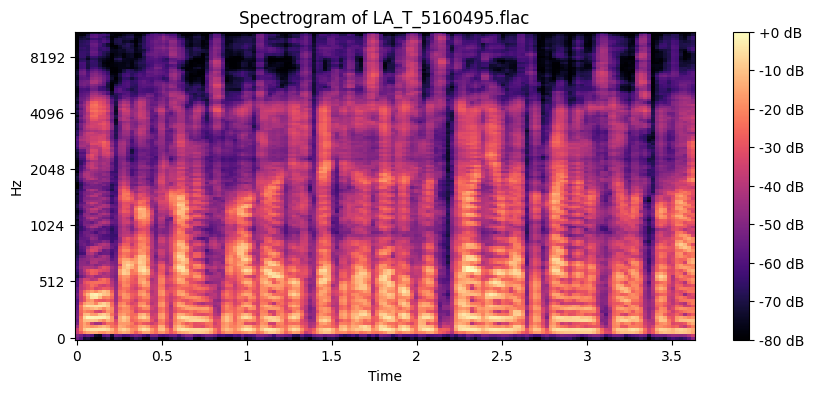

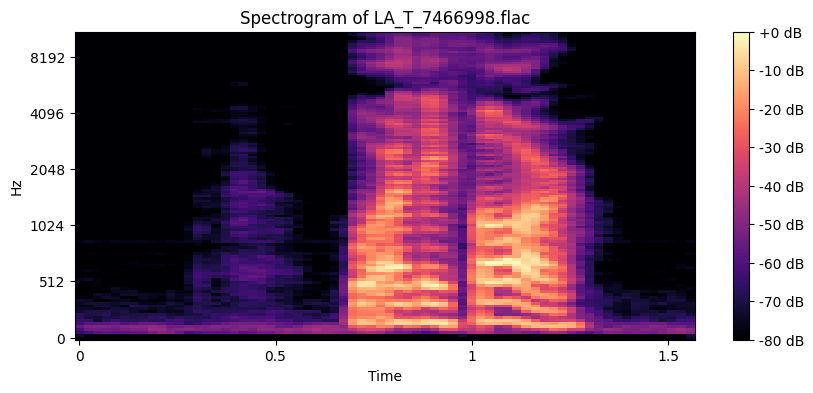

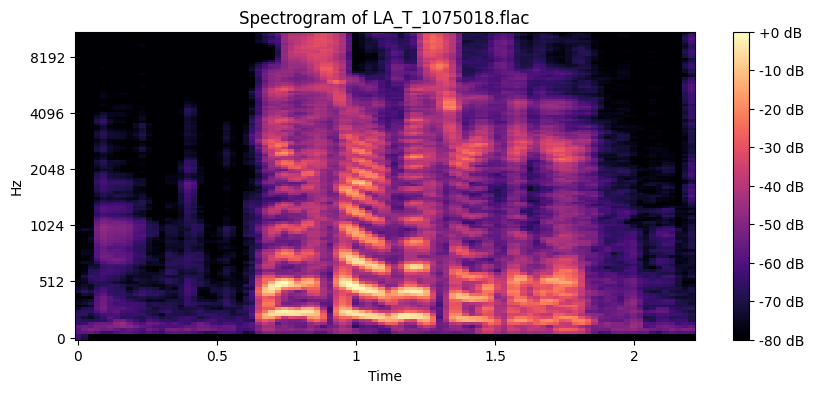

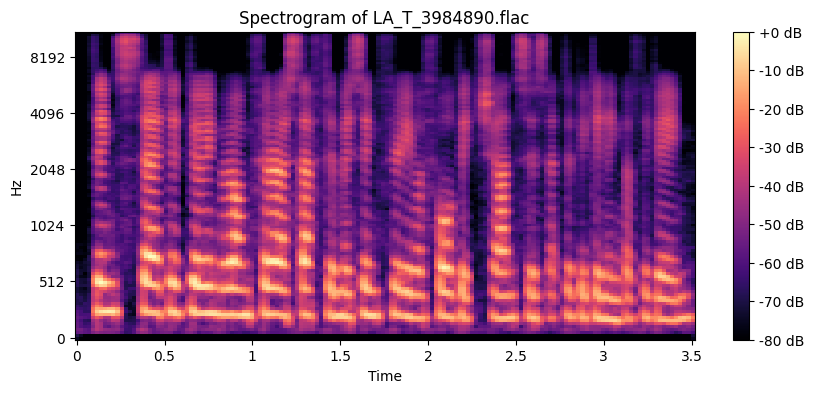

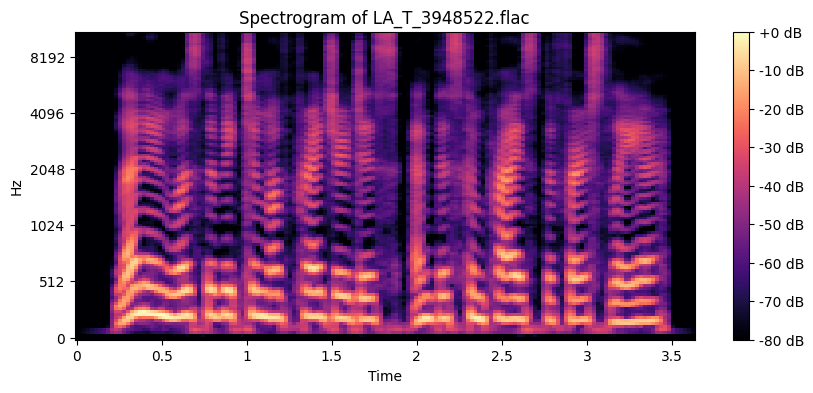

In [5]:
# Function to load and process audio files
def load_and_process_audio(file_path):
    # Load audio file
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)

    return spectrogram

# Get the list of FLAC files
flac_files = [file for file in os.listdir(DATASET_PATH) if file.endswith(".flac")]

# Process the first 5 files
for i in range(5):
    file_path = os.path.join(DATASET_PATH, flac_files[i])
    spectrogram = load_and_process_audio(file_path)

    # Display the spectrogram (optional)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {flac_files[i]}')
    plt.show()

In [6]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [8]:
# Convert the lists to numpy arrays for easier manipulation
X = np.array(X)
y = np.array(y)

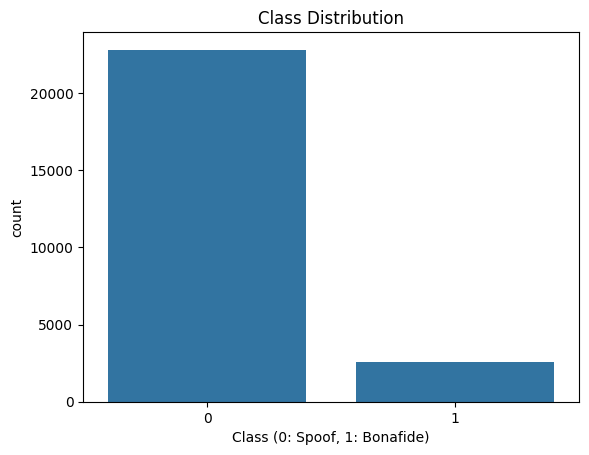

In [9]:
# Display class distribution
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Class (0: Spoof, 1: Bonafide)')
plt.show()

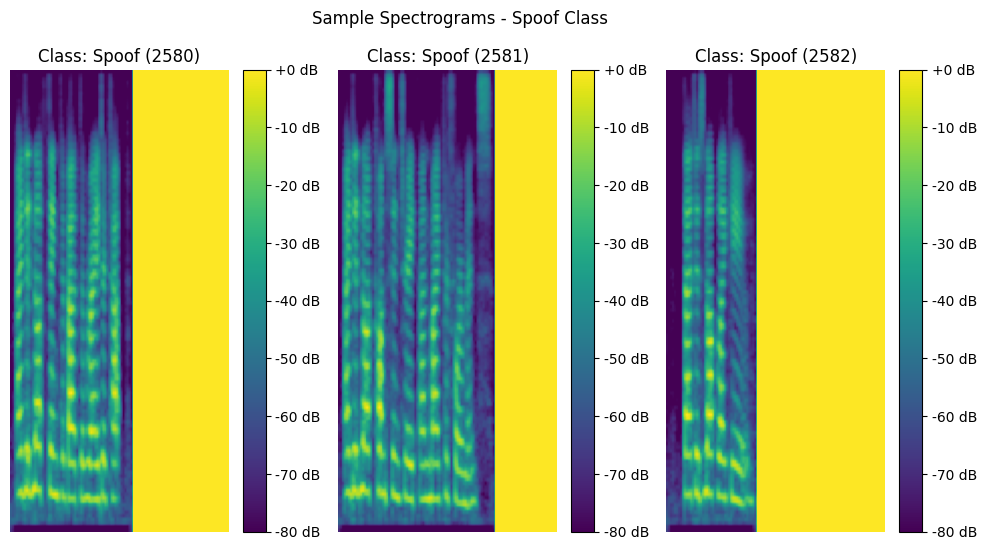

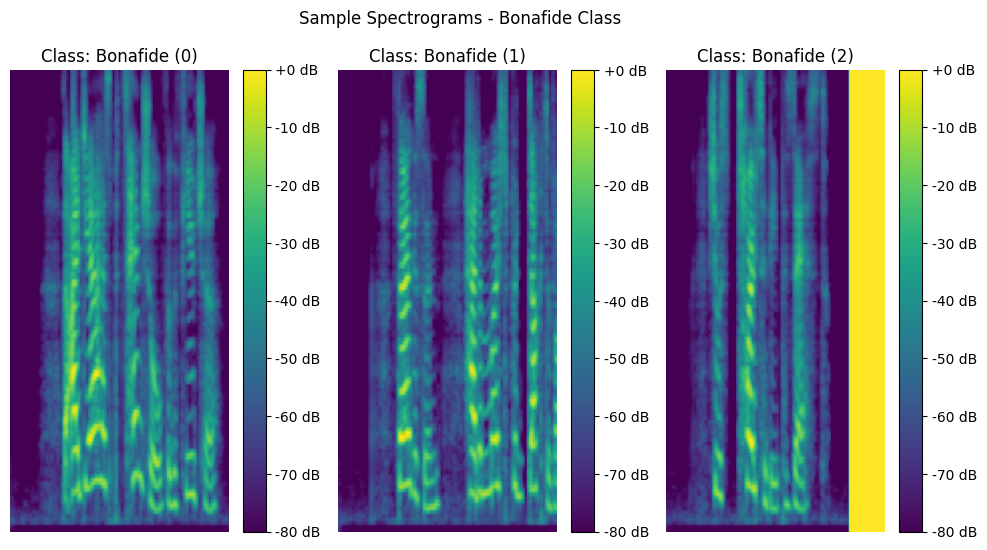

In [10]:
# Display a few sample spectrograms from class 0 (spoof)
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    spoof_index = np.where(y == 0)[0][i]
    plt.imshow(X[spoof_index], cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'Class: Spoof ({spoof_index})')
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')

plt.suptitle('Sample Spectrograms - Spoof Class')
plt.show()

# Display a few sample spectrograms from class 1 (bonafide)
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    bonafide_index = np.where(y == 1)[0][i]
    plt.imshow(X[bonafide_index], cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'Class: Bonafide ({bonafide_index})')
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')

plt.suptitle('Sample Spectrograms - Bonafide Class')
plt.show()


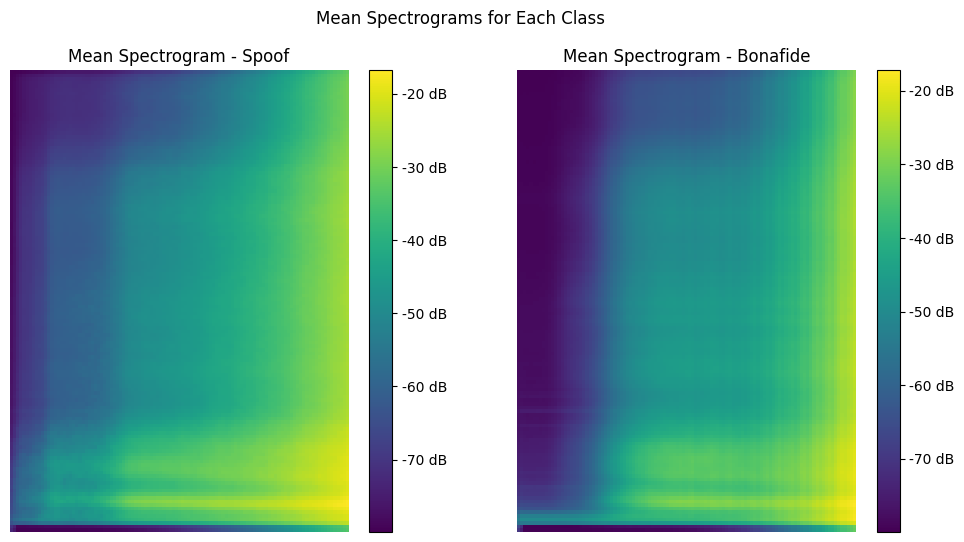

In [11]:
# Display mean spectrogram for each class
mean_spectrogram_spoof = np.mean(X[y == 0], axis=0)
mean_spectrogram_bonafide = np.mean(X[y == 1], axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mean_spectrogram_spoof, cmap='viridis', origin='lower', aspect='auto')
plt.title('Mean Spectrogram - Spoof')
plt.colorbar(format='%+2.0f dB')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_spectrogram_bonafide, cmap='viridis', origin='lower', aspect='auto')
plt.title('Mean Spectrogram - Bonafide')
plt.colorbar(format='%+2.0f dB')
plt.axis('off')

plt.suptitle('Mean Spectrograms for Each Class')
plt.show()

In [12]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=model_input, outputs=model_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Implement early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 109, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 107, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 53, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 51, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 48000)             0     

In [17]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20


2024-03-13 20:23:23.673062: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-13 20:23:23.766547: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 20:23:24.055544: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 20:23:24.483029: I external/local_xla/xla/service/service.cc:168] XLA service 0x7884889eafc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 20:23:24.483044: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-13 20:23:24.489449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710341604.540063    7317 devic

635/635 [==============================] - 10s 12ms/step - loss: 0.7526 - accuracy: 0.8986 - val_loss: 0.2200 - val_accuracy: 0.9139
Epoch 2/20
 13/635 [..............................] - ETA: 6s - loss: 0.2220 - accuracy: 0.9231

/home/laptop/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


635/635 [==============================] - 7s 11ms/step - loss: 0.2122 - accuracy: 0.9129 - val_loss: 0.1664 - val_accuracy: 0.9309
Epoch 3/20
635/635 [==============================] - 7s 11ms/step - loss: 0.1806 - accuracy: 0.9253 - val_loss: 0.1372 - val_accuracy: 0.9480
Epoch 4/20
635/635 [==============================] - 7s 11ms/step - loss: 0.1627 - accuracy: 0.9337 - val_loss: 0.1379 - val_accuracy: 0.9444
Epoch 5/20
635/635 [==============================] - 7s 11ms/step - loss: 0.1388 - accuracy: 0.9442 - val_loss: 0.1066 - val_accuracy: 0.9578
Epoch 6/20
635/635 [==============================] - 7s 11ms/step - loss: 0.1092 - accuracy: 0.9560 - val_loss: 0.0721 - val_accuracy: 0.9708
Epoch 7/20
635/635 [==============================] - 7s 11ms/step - loss: 0.0867 - accuracy: 0.9669 - val_loss: 0.0641 - val_accuracy: 0.9744
Epoch 8/20
635/635 [==============================] - 7s 11ms/step - loss: 0.0747 - accuracy: 0.9716 - val_loss: 0.0949 - val_accuracy: 0.9638
Epoch 9/20

In [18]:
# Evaluate the model on the validation set
evaluation_results = model.evaluate(X_val, y_val)
print(f"Validation Loss: {evaluation_results[0]}, Validation Accuracy: {evaluation_results[1]}")


159/159 [==============================] - 1s 4ms/step - loss: 0.0231 - accuracy: 0.9921
Validation Loss: 0.023055285215377808, Validation Accuracy: 0.9921197891235352


159/159 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4571
           1       0.95      0.97      0.96       505

    accuracy                           0.99      5076
   macro avg       0.98      0.98      0.98      5076
weighted avg       0.99      0.99      0.99      5076



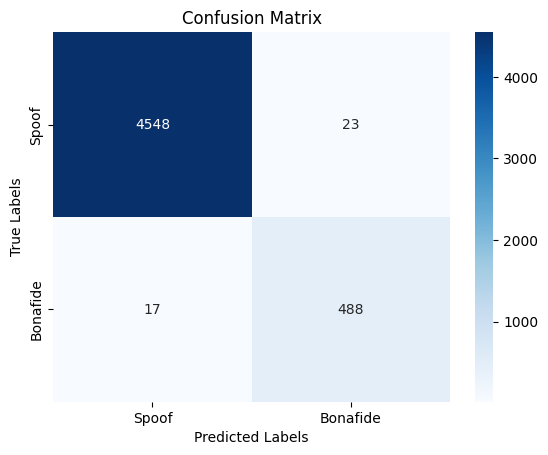

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Convert one-hot encoded predictions and true labels back to original labels
y_val_labels = np.argmax(y_val, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Print classification report
print(classification_report(y_val_labels, y_val_pred_labels))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_val_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Bonafide'], yticklabels=['Spoof', 'Bonafide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Few Misclassified Spectrograms

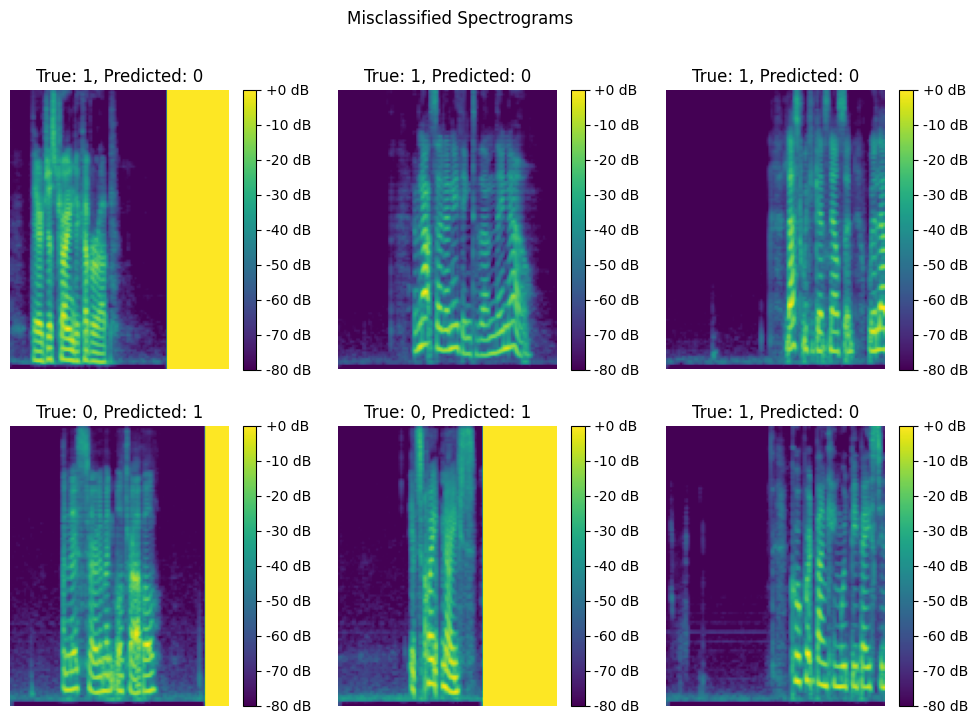

In [20]:
misclassified_indices = np.where(y_val_labels != y_val_pred_labels)[0]

# Display a few misclassified spectrograms
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    misclassified_index = misclassified_indices[i]
    plt.imshow(X_val[misclassified_index], cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'True: {y_val_labels[misclassified_index]}, Predicted: {y_val_pred_labels[misclassified_index]}')
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')
plt.suptitle('Misclassified Spectrograms')
plt.show()

In [21]:
# Function to load and process audio files
def load_and_process_audio(file_path):
    # Load audio file
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)

    return spectrogram

# Load and preprocess unseen data for evaluation
UNSEEN_DATASET_PATH = "LA/ASVspoof2019_LA_eval/flac"
UNSEEN_LABEL_FILE_PATH = "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

# Get the list of FLAC files
unseen_flac_files = [file for file in os.listdir(UNSEEN_DATASET_PATH) if file.endswith(".flac")]

# Process the first 5 files
X_unseen = []
MAX_TIME_STEPS = 109  # Or use the appropriate value based on your training data

for i in range(5):  # Change the range accordingly
    file_path = os.path.join(UNSEEN_DATASET_PATH, unseen_flac_files[i])
    spectrogram = load_and_process_audio(file_path)

    # Ensure all spectrograms have the same width (time steps)
    if spectrogram.shape[1] < MAX_TIME_STEPS:
        spectrogram = np.pad(spectrogram, ((0, 0), (0, MAX_TIME_STEPS - spectrogram.shape[1])), mode='constant')
    else:
        spectrogram = spectrogram[:, :MAX_TIME_STEPS]

    X_unseen.append(spectrogram)

# Convert the list to a numpy array
X_unseen = np.array(X_unseen)

# Load the saved model
from tensorflow.keras.models import load_model
saved_model_path = "best_model.h5"
loaded_model = load_model(saved_model_path)

# Make predictions on unseen data
y_unseen_pred = loaded_model.predict(X_unseen)

# Convert one-hot encoded predictions back to original labels
y_unseen_pred_labels = np.argmax(y_unseen_pred, axis=1)

# Perform further analysis or actions with the predictions
# ...
# Define class names
class_names = ['Spoof', 'Bonafide']

# Map predicted labels to class names
predicted_class_names = [class_names[label] for label in y_unseen_pred_labels]

# Print the predicted class names
print("Predicted Labels for Unseen Data:")
for i, predicted_class in enumerate(predicted_class_names):
    print(f"File {i+1}: {predicted_class}")

1/1 [==============================] - 0s 108ms/step
Predicted Labels for Unseen Data:
File 1: Spoof
File 2: Spoof
File 3: Spoof
File 4: Spoof
File 5: Spoof


In [22]:
# Load and preprocess true labels for evaluation
true_labels_path = "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

# Read true labels from the file
true_labels = {}
with open(true_labels_path, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    true_labels[file_name] = label

# Extract true labels for the processed files
true_labels_unseen = [true_labels[os.path.splitext(file)[0]] for file in unseen_flac_files[:5]]

# Compare predicted labels with true labels and print results
for i, (predicted_label, true_label, file_name) in enumerate(zip(y_unseen_pred_labels, true_labels_unseen, unseen_flac_files[:5])):
    prediction_correct = predicted_label == true_label
    prediction_result = "Correct" if prediction_correct else "Incorrect"
    
    print(f"File {i + 1}: {file_name}, Predicted: {predicted_label} (Spoof/Bonafide), True: {true_label} (Spoof/Bonafide), Result: {prediction_result}")



File 1: LA_E_6276864.flac, Predicted: 0 (Spoof/Bonafide), True: 1 (Spoof/Bonafide), Result: Incorrect
File 2: LA_E_9414833.flac, Predicted: 0 (Spoof/Bonafide), True: 0 (Spoof/Bonafide), Result: Correct
File 3: LA_E_9760948.flac, Predicted: 0 (Spoof/Bonafide), True: 0 (Spoof/Bonafide), Result: Correct
File 4: LA_E_1001893.flac, Predicted: 0 (Spoof/Bonafide), True: 0 (Spoof/Bonafide), Result: Correct
File 5: LA_E_7855456.flac, Predicted: 0 (Spoof/Bonafide), True: 0 (Spoof/Bonafide), Result: Correct


1/1 [==============================] - 0s 244ms/step


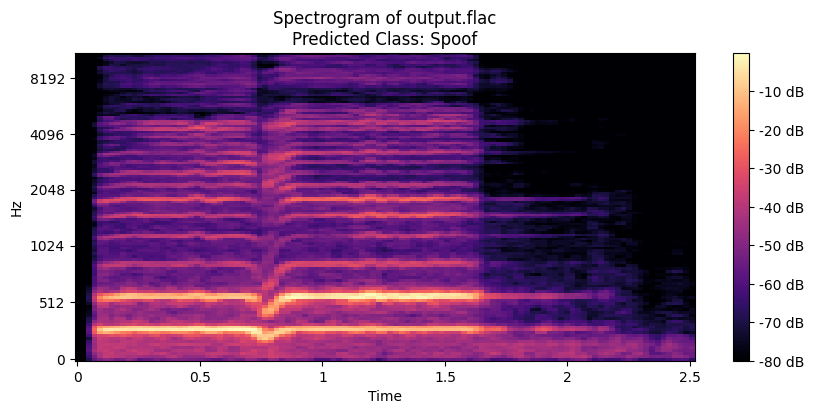

The predicted class for the new audio file is: Spoof


In [24]:
import librosa.display

# Function to load and process audio files
def load_and_process_audio(file_path, sample_rate, duration, n_mels, max_time_steps):
    # Load audio file
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)

    # Ensure all spectrograms have the same width (time steps)
    if spectrogram.shape[1] < max_time_steps:
        spectrogram = np.pad(spectrogram, ((0, 0), (0, max_time_steps - spectrogram.shape[1])), mode='constant')
    else:
        spectrogram = spectrogram[:, :max_time_steps]

    return spectrogram

# Function to predict the class of an audio file and display the spectrogram
def predict_and_display(file_path, model, sample_rate, duration, n_mels, max_time_steps):
    # Load and process the audio
    spectrogram = load_and_process_audio(file_path, sample_rate, duration, n_mels, max_time_steps)

    # Add channel dimension to the spectrogram
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    # Make predictions using the loaded model
    predictions = model.predict(np.expand_dims(spectrogram, axis=0))  # Add batch dimension

    # Convert one-hot encoded predictions back to original labels
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Map the predicted label to class name
    class_names = ['Spoof', 'Bonafide']
    predicted_class = class_names[predicted_label]

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram[:, :, 0], ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {file_path}\nPredicted Class: {predicted_class}')
    plt.show()

    return predicted_class

# Example: Predict the class of a new audio file and display the spectrogram
new_audio_file_path = "output.flac"
predicted_class = predict_and_display(new_audio_file_path, loaded_model, SAMPLE_RATE, DURATION, N_MELS, MAX_TIME_STEPS)

print(f"The predicted class for the new audio file is: {predicted_class}")

In [26]:
from moviepy.editor import VideoFileClip

def convert_mp4_to_flac(input_file, output_file):
    video_clip = VideoFileClip(input_file)
    audio_clip = video_clip.audio

    audio_clip.write_audiofile(output_file, codec='flac')

if __name__ == "__main__":
    input_file_path = "fake voice.mp4"  # Replace with your MP4 file path
    output_file_path = "output.flac"  # Replace with desired FLAC file path

    convert_mp4_to_flac(input_file_path, output_file_path)


MoviePy - Writing audio in output.flac


MoviePy - Done.
